In [39]:
%pylab inline 

from skimage.io import imread, imshow

from skimage import io, data, img_as_uint, img_as_ubyte, img_as_float
from skimage import color, transform
from skimage.transform import rescale
import cv2
import Queue

from skimage.filters import threshold_otsu, threshold_adaptive
from skimage.draw import circle, circle_perimeter

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'imshow', 'imread', 'table']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [40]:
#Template Matching 

def ncorrMatching(image, template, thresh):
    
    hpad = template.shape[0] / 2 
    wpad = template.shape[1] / 2

    nheight = ((image.shape[0] - template.shape[0]) / 1) + 1
    nwidth = ((image.shape[1] - template.shape[1]) / 1) + 1
    
    template_mean = np.mean(template)
    template_std = np.std(template)

    template = (template - template_mean) / (template_std + 1e-12)
                
    #print "Min is ", np.min(image)
    #print "Max is ", np.max(image)
    
    #ipad = np.pad(image, (hpad, wpad), 'constant')
    
    #print "Ipad size is ", ipad.shape
    
    #plt.figure()
    #plt.imshow(ipad, cmap='gray')
    
    
    res = np.zeros((image.shape))
    #res[:, :] = 1
    
    for i in range(0, image.shape[0]):
        for j in range(0, image.shape[1]):
            if image[i: i+template.shape[0], j: j+template.shape[1]].shape == template.shape:
                window = image[i: i+template.shape[0], j: j+template.shape[1]]
                window_mean = np.mean(window)
                window_std = np.std(window)
                window = (window - window_mean) / (window_std + 1e-12)
                tot = np.dot(window.flatten(), template.flatten())
                res[i + hpad, j + wpad] = tot
            
    
    i, j = np.unravel_index(res.argmax(), res.shape)
    
    print "Max is", np.max(res)
    maxim = np.max(res)
    
    #thresh = 1000
    
    greater = res > thresh
    lesser = res <= thresh
        
    res[greater] = 1
    res[lesser] = 0
    
    return res, i, j, maxim

In [41]:
#Generalized Hough Transform 

def buildRefTable(im):
    """
    builds the reference table for the given input template image
    :param im: input binary image
    :return:
        table = a reconstructed reference table...
    """
    rx, ry = im.shape[0] / 2, im.shape[1] / 2
    
    gx = np.zeros((im.shape))
    gy = np.zeros((im.shape))
    
    filt = np.array([-1, 0, 1])
    
    for i in range(1, im.shape[0] - 1):
        for j in range(1, im.shape[1] - 1):
            if im[i, j] == 255:
                gx[i, j] = np.sum( im[i-1:i+1+1, j].flatten() * filt.flatten() )
                gy[i, j] = np.sum( im[i, j-1:j+1+1].flatten() * filt.flatten() )
                
    grad_direction = np.arctan2(gy, gx)
    
    #plt.imshow(gx, cmap='gray')
    #plt.figure()
    #plt.imshow(gy, cmap='gray')
    #plt.figure()
    #plt.imshow(grad_direction, cmap='gray')
    
    arr = []
   
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if im[i, j] == 255:
                if not (grad_direction[i, j] in arr):
                    arr.append(grad_direction[i, j])
                    
    arr.sort()
    arr2 = [None] * len(arr)
        
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if im[i, j] == 255:
                idx = arr.index(grad_direction[i, j])
                temparr = []
                temparr.append(rx - i)
                temparr.append(ry - j)
                if arr2[idx] == None:
                    arr2[idx] = [temparr]
                else:
                    arr2[idx].append(temparr)
    
    #for i in range(len(arr)):
    #    print arr2[i]
    #    print
           
    
    return arr2

def matchTable(im, table):
    """

    :param im: input binary image, for searching template
    :param table: table for template
    :return:
        accumulator with searched votes
    """
    # matches the reference table with the given input
    # image for testing generalized Hough Transform
    #m, n = im.shape
    
    gy = np.zeros((im.shape))
    gx = np.zeros((im.shape))
    
    filt = np.array([[-1, 0, 1]])
    
    acc = np.zeros((im.shape[0], im.shape[1]))
    
    for i in range(1, im.shape[0]-1):
        for j in range(1, im.shape[1]-1):
            gx[i, j] = np.sum( im[i-1:i+1+1, j] * filt.T.flatten() )
            gy[i, j] = np.sum( im[i, j-1:j+1+1] * filt.flatten() )
    
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if im[i, j] == 255:
                ori = np.arctan2(gy[i, j], gx[i, j])
                for k in table:
                    for l in k:
                        xc = l[0] + i
                        yc = l[1] + j
                        if xc < im.shape[0] and yc < im.shape[1]:
                            acc[xc, yc] += 1
                        #else:
                        #    print "hello ", xc, yc
    return acc

def findMaxima(acc):
    """

    :param acc: accumulator array
    :return:
        maxval: maximum value found
        ridx: row index of the maxval
        cidx: column index of the maxval
    """
    
    maxval = np.max(acc)
    ridx, cidx= unravel_index(acc.argmax(), acc.shape)
    return maxval, ridx, cidx

In [42]:
img1 = color.rgb2gray(io.imread('DataSet/img1.jpg'))
img2 = color.rgb2gray(io.imread('DataSet/img2.jpg'))
img3 = color.rgb2gray(io.imread('DataSet/img3.jpg'))
img4 = color.rgb2gray(io.imread('DataSet/img4.jpg'))

#img1 = img_as_uint(img1)
#img2 = img_as_uint(img2)
#img3 = img_as_uint(img3)
#img4 = img_as_uint(img4)

print img1.shape
print img1.dtype

img1 = transform.rescale(img1, 0.25)
img2 = transform.rescale(img2, 0.25)
img3 = transform.rescale(img3, 0.25)
img4 = transform.rescale(img4, 0.25)

(3243, 2306)
float64


(809, 572)


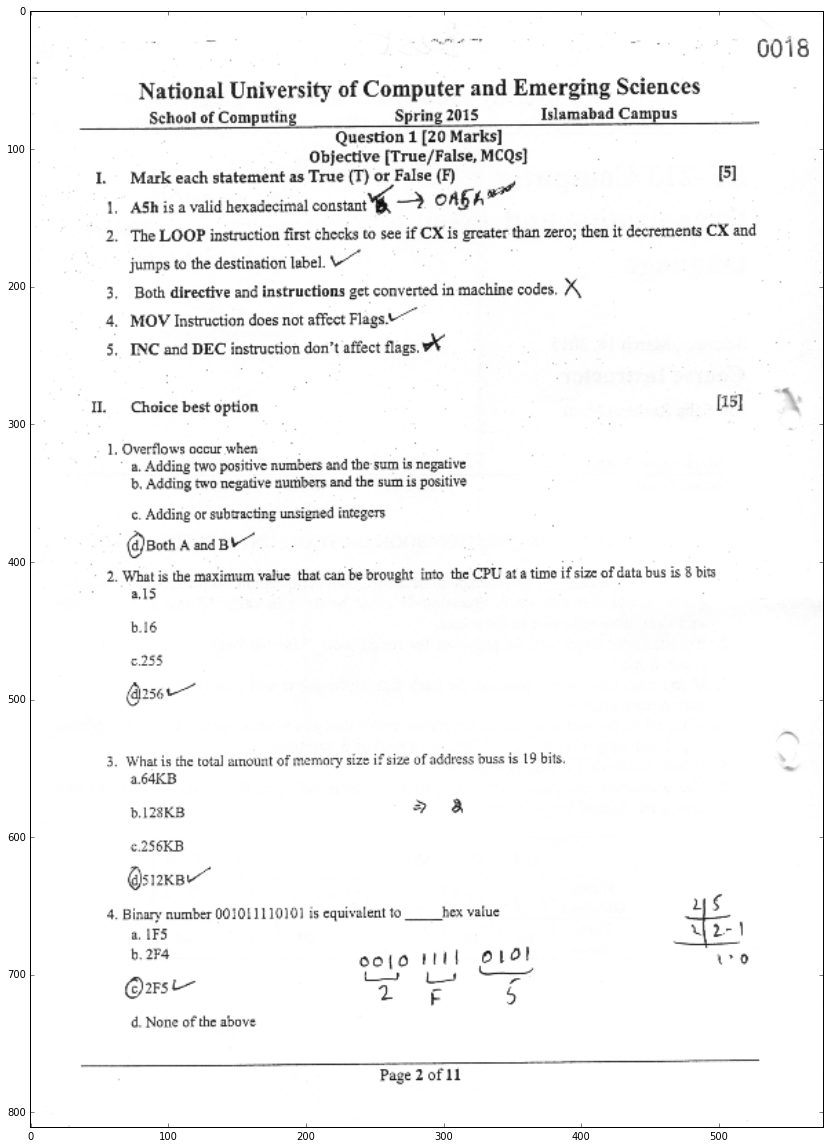

In [43]:
figure(figsize = (20, 20))
print img4.shape
plt.imshow(img1, cmap='gray')

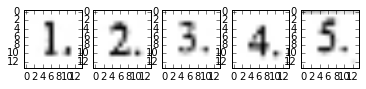

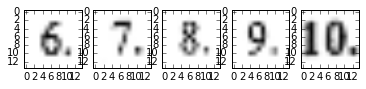

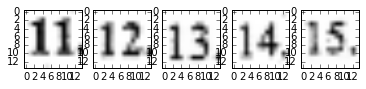

In [44]:
x = 319
y = 59
spread = 7
number1_template = img1[x-spread:x+spread, y-spread:y+spread]
#plt.imshow(number1_template, cmap='gray')

x = 411
y = 59
spread = 7
number2_template = img1[x-spread:x+spread, y-spread:y+spread]
#plt.imshow(number2_template, cmap='gray')

x = 546
y = 59
spread = 7
number3_template = img1[x-spread:x+spread, y-spread:y+spread]
#plt.imshow(number3_template, cmap='gray')

x = 656
y = 59
spread = 7
number4_template = img1[x-spread:x+spread, y-spread:y+spread]
#plt.imshow(number4_template, cmap='gray')

x = 95
y = 30
spread = 7
number5_template = img2[x-spread:x+spread, y-spread:y+spread]
#plt.imshow(number5_template, cmap='gray')

x = 197
y = 30
spread = 7
number6_template = img2[x-spread:x+spread, y-spread:y+spread]
#plt.imshow(number6_template, cmap='gray')

x = 322
y = 30
spread = 7
number7_template = img2[x-spread:x+spread, y-spread:y+spread]
#plt.imshow(number7_template, cmap='gray')

x = 460
y = 31
spread = 7
number8_template = img2[x-spread:x+spread, y-spread:y+spread]
#plt.imshow(number8_template, cmap='gray')

x = 595
y = 31
spread = 7
number9_template = img2[x-spread:x+spread, y-spread:y+spread]
#plt.imshow(number9_template, cmap='gray')

x = 82
y = 32
spread = 7
number10_template = img3[x-spread:x+spread, y-spread:y+spread]
#plt.imshow(number10_template, cmap='gray')

x = 186
y = 30
spread = 7
number11_template = img3[x-spread:x+spread, y-spread:y+spread]
#plt.imshow(number11_template, cmap='gray')

x = 449
y = 29
spread = 7
number12_template = img3[x-spread:x+spread, y-spread:y+spread]
#plt.imshow(number12_template, cmap='gray')

x = 113
y = 57
spread = 7
number13_template = img4[x-spread:x+spread, y-spread:y+spread]
#plt.imshow(number13_template, cmap='gray')

x = 237
y = 56
spread = 7
number14_template = img4[x-spread:x+spread, y-spread:y+spread]
#plt.imshow(number14_template, cmap='gray')

x = 387
y = 56
spread = 7
number15_template = img4[x-spread:x+spread, y-spread:y+spread]
#plt.imshow(number15_template, cmap='gray')


f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
ax1.imshow(number1_template, cmap='gray')
ax2.imshow(number2_template, cmap='gray')
ax3.imshow(number3_template, cmap='gray')
ax4.imshow(number4_template, cmap='gray')
ax5.imshow(number5_template, cmap='gray')

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
ax1.imshow(number6_template, cmap='gray')
ax2.imshow(number7_template, cmap='gray')
ax3.imshow(number8_template, cmap='gray')
ax4.imshow(number9_template, cmap='gray')
ax5.imshow(number10_template, cmap='gray')

f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
ax1.imshow(number11_template, cmap='gray')
ax2.imshow(number12_template, cmap='gray')
ax3.imshow(number13_template, cmap='gray')
ax4.imshow(number14_template, cmap='gray')
ax5.imshow(number15_template, cmap='gray')

In [45]:
io.imsave('number1.jpg', number1_template)
io.imsave('number2.jpg', number2_template)
io.imsave('number3.jpg', number3_template)
io.imsave('number4.jpg', number4_template)
io.imsave('number5.jpg', number5_template)
io.imsave('number6.jpg', number6_template)
io.imsave('number7.jpg', number7_template)
io.imsave('number8.jpg', number8_template)
io.imsave('number9.jpg', number9_template)
io.imsave('number10.jpg', number10_template)
io.imsave('number11.jpg', number11_template)
io.imsave('number12.jpg', number12_template)
io.imsave('number13.jpg', number13_template)
io.imsave('number14.jpg', number14_template)
io.imsave('number15.jpg', number15_template)

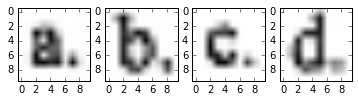

In [46]:
x = 332
y = 77
spread = 5
optiona_template = img1[x-spread:x+spread, y-spread:y+spread]

x = 344
y = 77
spread = 5
optionb_template = img1[x-spread:x+spread, y-spread:y+spread]

x = 367
y = 77
spread = 5
optionc_template = img1[x-spread:x+spread, y-spread:y+spread]

x = 735
y = 77
spread = 5
optiond_template = img1[x-spread:x+spread, y-spread:y+spread]

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.imshow(optiona_template, cmap='gray')
ax2.imshow(optionb_template, cmap='gray')
ax3.imshow(optionc_template, cmap='gray')
ax4.imshow(optiond_template, cmap='gray')

In [53]:
index_array1 = []

output, index1, index2, maxi = ncorrMatching(img1, number1_template, 190)
index_array1.append([index1, index2])
output, index1, index2, maxi = ncorrMatching(img1, number2_template, 190)
index_array1.append([index1, index2])
output, index1, index2, maxi = ncorrMatching(img1, number3_template, 190)
index_array1.append([index1, index2])
output, index1, index2, maxi = ncorrMatching(img1, number4_template, 190)
index_array1.append([index1, index2])

Max is 195.999999998
Max is 195.999999998
Max is 195.999999997
Max is 195.999999998


In [49]:
index_array2 = []

output, index1, index2, maxi = ncorrMatching(img2, number5_template, 190)
index_array2.append([index1, index2])
output, index1, index2, maxi = ncorrMatching(img2, number6_template, 190)
index_array2.append([index1, index2])
output, index1, index2, maxi = ncorrMatching(img2, number7_template, 190)
index_array2.append([index1, index2])
output, index1, index2, maxi = ncorrMatching(img2, number8_template, 190)
index_array2.append([index1, index2])
output, index1, index2, maxi = ncorrMatching(img2, number9_template, 190)
index_array2.append([index1, index2])

Max is 195.999999998
Max is 195.999999998
Max is 195.999999998
Max is 195.999999998
Max is 195.999999998


In [50]:
index_array3 = []

output, index1, index2, maxi = ncorrMatching(img3, number10_template, 190)
index_array3.append([index1, index2])
output, index1, index2, maxi = ncorrMatching(img3, number11_template, 190)
index_array3.append([index1, index2])
output, index1, index2, maxi = ncorrMatching(img3, number12_template, 190)
index_array3.append([index1, index2])

Max is 195.999999999
Max is 195.999999999
Max is 195.999999998


In [51]:
index_array4 = []

output, index1, index2, maxi = ncorrMatching(img4, number13_template, 190)
index_array4.append([index1, index2])
output, index1, index2, maxi = ncorrMatching(img4, number14_template, 190)
index_array4.append([index1, index2])
output, index1, index2, maxi = ncorrMatching(img4, number15_template, 190)
index_array4.append([index1, index2])

Max is 195.999999998
Max is 195.999999998
Max is 195.999999998


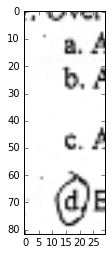

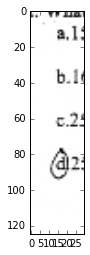

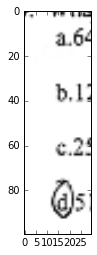

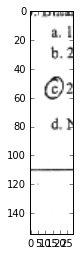

In [54]:
a = index_array1[0][0] #- 10
b = index_array1[1][0] - 10
c = index_array1[0][1] #- 10
d = index_array1[0][1] + 30
question1_img = img1[a:b, c:d]
plt.imshow(question1_img, cmap='gray')
plt.figure()

a = index_array1[1][0] #- 10
b = index_array1[2][0] - 10
c = index_array1[1][1] #- 10
d = index_array1[1][1] + 30
question2_img = img1[a:b, c:d]
plt.imshow(question2_img, cmap='gray')
plt.figure()

a = index_array1[2][0] #- 10
b = index_array1[3][0] - 10
c = index_array1[2][1] #- 10
d = index_array1[2][1] + 30
question3_img = img1[a:b, c:d]
plt.imshow(question3_img, cmap='gray')
plt.figure()

a = index_array1[3][0] #- 10
b = index_array1[3][0] - 10
c = index_array1[3][1] #- 10
d = index_array1[3][1] + 30
question4_img = img1[a:, c:d]
plt.imshow(question4_img, cmap='gray')
plt.figure()

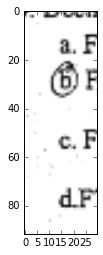

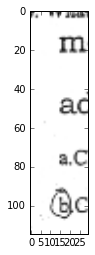

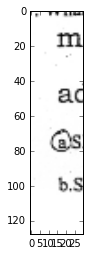

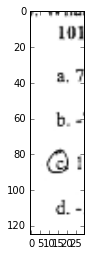

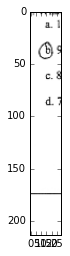

In [55]:
a = index_array2[0][0] #- 10
b = index_array2[1][0] - 10
c = index_array2[0][1] #- 10
d = index_array2[0][1] + 30
question5_img = img2[a:b, c:d]
plt.imshow(question5_img, cmap='gray')
plt.figure()

a = index_array2[1][0] #- 10
b = index_array2[2][0] - 10
c = index_array2[1][1] #- 10
d = index_array2[1][1] + 30
question6_img = img2[a:b, c:d]
plt.imshow(question6_img, cmap='gray')
plt.figure()

a = index_array2[2][0] #- 10
b = index_array2[3][0] - 10
c = index_array2[2][1] #- 10
d = index_array2[2][1] + 30
question7_img = img2[a:b, c:d]
plt.imshow(question7_img, cmap='gray')
plt.figure()

a = index_array2[3][0] #- 10
b = index_array2[4][0] - 10
c = index_array2[3][1] #- 10
d = index_array2[3][1] + 30
question8_img = img2[a:b, c:d]
plt.imshow(question8_img, cmap='gray')
plt.figure()

a = index_array2[4][0] #- 10
b = index_array2[4][0] - 10
c = index_array2[4][1] #- 10
d = index_array2[4][1] + 30
question9_img = img2[a:, c:d]
plt.imshow(question9_img, cmap='gray')
plt.figure()

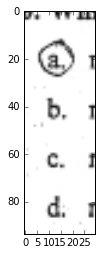

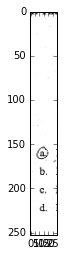

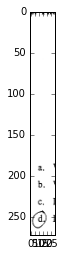

In [56]:
a = index_array3[0][0] #- 10
b = index_array3[1][0] - 10
c = index_array3[0][1] #- 10
d = index_array3[0][1] + 30
question10_img = img3[a:b, c:d]
plt.imshow(question10_img, cmap='gray')
plt.figure()

a = index_array3[1][0] #- 10
b = index_array3[2][0] - 10
c = index_array3[1][1] #- 10
d = index_array3[1][1] + 30
question11_img = img3[a:b, c:d]
plt.imshow(question11_img, cmap='gray')
plt.figure()

a = index_array3[2][0] #- 10
b = index_array3[2][0] - 10
c = index_array3[2][1] #- 10
d = index_array3[2][1] + 30
question12_img = img3[a:, c:d]
plt.imshow(question12_img, cmap='gray')
plt.figure()

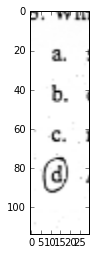

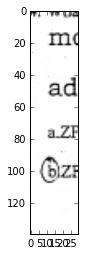

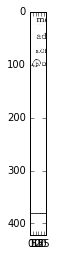

In [57]:
a = index_array4[0][0] #- 10
b = index_array4[1][0] - 10
c = index_array4[0][1] #- 10
d = index_array4[0][1] + 30
question13_img = img4[a:b, c:d]
plt.imshow(question13_img, cmap='gray')
plt.figure()

a = index_array4[1][0] #- 10
b = index_array4[2][0] - 10
c = index_array4[1][1] #- 10
d = index_array4[1][1] + 30
question14_img = img4[a:b, c:d]
plt.imshow(question14_img, cmap='gray')
plt.figure()

a = index_array4[2][0] #- 10
b = index_array4[2][0] - 10
c = index_array4[2][1] #- 10
d = index_array4[2][1] + 30
question15_img = img4[a:, c:d]
plt.imshow(question15_img, cmap='gray')
plt.figure()

In [58]:
student_responses = {}

Max is 8.18486854757
Max is 6.99923674806
Max is 4.98710087729
Max is 14.5035063915


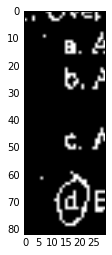

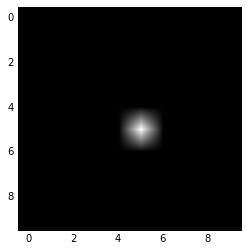

In [59]:
#Question 1

hough_template = np.zeros((15, 15))
rr, cc = circle_perimeter(hough_template.shape[0]/2, hough_template.shape[1]/2, 7)
hough_template[rr, cc] = 1
hough_template = 255 - hough_template

thresh1 = threshold_otsu(question1_img)
binary = question1_img > thresh1
binary  = 255 - binary

plt.imshow(binary, cmap='gray')
plt.figure()

thresh2 = threshold_otsu(hough_template)
binary2 = hough_template > thresh2
binary2 = 255 - binary2

im = binary
refim = binary2

#plt.imshow(im, cmap='gray')
#plt.figure()
#plt.imshow(refim, cmap='gray')
#plt.figure()

table = buildRefTable(refim)
#print table
acc = matchTable(im, table)
val, ridx, cidx = findMaxima(acc)

#print acc

#plt.imshow(acc, cmap='gray')

selected_answer = question1_img[ridx-5:ridx+5, cidx-5:cidx+5]
#plt.figure()
#plt.imshow(selected_answer, cmap='gray')

maximum_response = 0
maximum_option = ""

output, i, j, maxi = ncorrMatching(selected_answer, optiona_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "a"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optionb_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "b"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optionc_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "c"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optiond_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "d"
plt.figure()
plt.imshow(output, cmap='gray')

student_responses['1'] = maximum_option

Max is 48.9404205869
Max is 33.9826028765
Max is 46.5133218033
Max is 64.5713236843


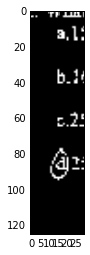

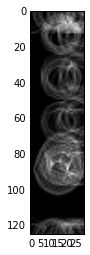

In [60]:
#Question 2

hough_template = np.zeros((20, 20))
rr, cc = circle_perimeter(hough_template.shape[0]/2, hough_template.shape[1]/2, 9)
hough_template[rr, cc] = 1
hough_template = 255 - hough_template

thresh1 = threshold_otsu(question2_img)
binary = question2_img > thresh1
binary  = 255 - binary

thresh2 = threshold_otsu(hough_template)
binary2 = hough_template > thresh2
binary2 = 255 - binary2

plt.imshow(binary, cmap='gray')
plt.figure()

im = binary
refim = binary2

table = buildRefTable(refim)
acc = matchTable(im, table)
val, ridx, cidx = findMaxima(acc)

plt.imshow(acc, cmap='gray')

selected_answer = question2_img[ridx-7:ridx+7, cidx-7:cidx+7]

maximum_response = 0
maximum_option = ""

output, i, j, maxi = ncorrMatching(selected_answer, optiona_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "a"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optionb_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "b"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optionc_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "c"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optiond_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "d"
#plt.figure()
#plt.imshow(output, cmap='gray')

student_responses['2'] = maximum_option

Max is 28.6591707842
Max is 28.7636990705
Max is 31.7397543495
Max is 53.4771452563


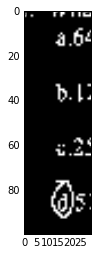

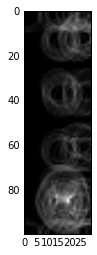

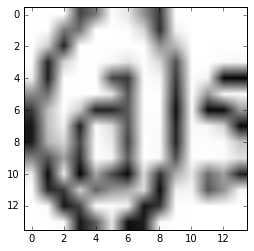

In [61]:
#Question 3

hough_template = np.zeros((15, 15))
rr, cc = circle_perimeter(hough_template.shape[0]/2, hough_template.shape[1]/2, 7)
hough_template[rr, cc] = 1
hough_template = 255 - hough_template

thresh1 = threshold_otsu(question3_img)
binary = question3_img > thresh1
binary  = 255 - binary

thresh2 = threshold_otsu(hough_template)
binary2 = hough_template > thresh2
binary2 = 255 - binary2

plt.imshow(binary, cmap='gray')
plt.figure()

im = binary
refim = binary2

table = buildRefTable(refim)
acc = matchTable(im, table)
val, ridx, cidx = findMaxima(acc)

plt.figure()
plt.imshow(acc, cmap='gray')

selected_answer = question3_img[ridx-7:ridx+7, cidx-7:cidx+7]

plt.figure()
plt.imshow(selected_answer, cmap='gray')

maximum_response = 0
maximum_option = ""

output, i, j, maxi = ncorrMatching(selected_answer, optiona_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "a"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optionb_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "b"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optionc_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "c"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optiond_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "d"
#plt.figure()
#plt.imshow(output, cmap='gray')

student_responses['3'] = maximum_option

Max is 48.8523947899
Max is 33.6511957784
Max is 65.0090915149
Max is 42.0872546337


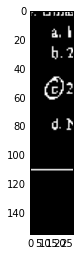

In [62]:
#Question 4

hough_template = np.zeros((15, 15))
rr, cc = circle_perimeter(hough_template.shape[0]/2, hough_template.shape[1]/2, 7)
hough_template[rr, cc] = 1
hough_template = 255 - hough_template

thresh1 = threshold_otsu(question4_img)
binary = question4_img > thresh1
binary  = 255 - binary

thresh2 = threshold_otsu(hough_template)
binary2 = hough_template > thresh2
binary2 = 255 - binary2

plt.imshow(binary, cmap='gray')
plt.figure()

im = binary
refim = binary2

table = buildRefTable(refim)
acc = matchTable(im, table)
val, ridx, cidx = findMaxima(acc)

selected_answer = question4_img[ridx-7:ridx+7, cidx-7:cidx+7]

maximum_response = 0
maximum_option = ""

output, i, j, maxi = ncorrMatching(selected_answer, optiona_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "a"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optionb_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "b"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optionc_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "c"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optiond_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "d"
#plt.figure()
#plt.imshow(output, cmap='gray')

student_responses['4'] = maximum_option

Max is 49.9684710701
Max is 54.8681889572
Max is 48.9260737707
Max is 54.9980947295


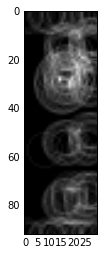

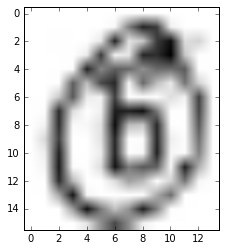

In [63]:
#Question 5

hough_template = np.zeros((15, 15))
rr, cc = circle_perimeter(hough_template.shape[0]/2, hough_template.shape[1]/2, 7)
hough_template[rr, cc] = 1
hough_template = 255 - hough_template

thresh1 = threshold_otsu(question5_img)
binary = question5_img > thresh1
binary  = 255 - binary

thresh2 = threshold_otsu(hough_template)
binary2 = hough_template > thresh2
binary2 = 255 - binary2

im = binary
refim = binary2

table = buildRefTable(refim)
acc = matchTable(im, table)
val, ridx, cidx = findMaxima(acc)

selected_answer = question5_img[ridx-8:ridx+8, cidx-5:cidx+9]

plt.figure()
plt.imshow(acc, cmap='gray')
plt.figure()
plt.imshow(selected_answer, cmap='gray')

maximum_response = 0
maximum_option = ""

output, i, j, maxi = ncorrMatching(selected_answer, optiona_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "a"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optionb_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "b"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optionc_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "c"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optiond_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "d"
#plt.figure()
#plt.imshow(output, cmap='gray')

student_responses['5'] = maximum_option

Max is 42.0318592424
Max is 55.3440625339
Max is 53.8402083579
Max is 34.927899794


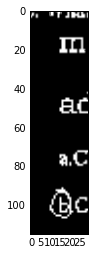

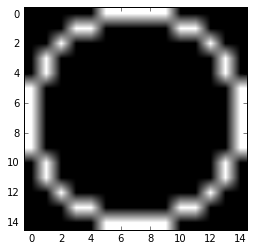

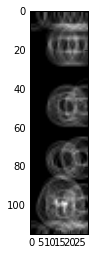

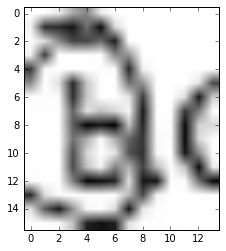

In [64]:
#Question 6

hough_template = np.zeros((15, 15))
rr, cc = circle_perimeter(hough_template.shape[0]/2, hough_template.shape[1]/2, 7)
hough_template[rr, cc] = 1
hough_template = 255 - hough_template

thresh1 = threshold_otsu(question6_img)
binary = question6_img > thresh1
binary  = 255 - binary

thresh2 = threshold_otsu(hough_template)
binary2 = hough_template > thresh2
binary2 = 255 - binary2

im = binary
refim = binary2

table = buildRefTable(refim)
acc = matchTable(im, table)
val, ridx, cidx = findMaxima(acc)

selected_answer = question6_img[ridx-8:ridx+8, cidx-5:cidx+9]

plt.imshow(binary, cmap='gray')
plt.figure()
plt.imshow(binary2, cmap='gray')

plt.figure()
plt.imshow(acc, cmap='gray')
plt.figure()
plt.imshow(selected_answer, cmap='gray')

maximum_response = 0
maximum_option = ""

output, i, j, maxi = ncorrMatching(selected_answer, optiona_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "a"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optionb_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "b"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optionc_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "c"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optiond_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "d"
#plt.figure()
#plt.imshow(output, cmap='gray')

student_responses['6'] = maximum_option

In [65]:
#Question 7

hough_template = np.zeros((15, 15))
rr, cc = circle_perimeter(hough_template.shape[0]/2, hough_template.shape[1]/2, 7)
hough_template[rr, cc] = 1
hough_template = 255 - hough_template

thresh1 = threshold_otsu(question7_img)
binary = question7_img > thresh1
binary  = 255 - binary

thresh2 = threshold_otsu(hough_template)
binary2 = hough_template > thresh2
binary2 = 255 - binary2

im = binary
refim = binary2

table = buildRefTable(refim)
acc = matchTable(im, table)
val, ridx, cidx = findMaxima(acc)

selected_answer = question7_img[ridx-8:ridx+8, cidx-5:cidx+9]

#plt.imshow(binary, cmap='gray')
#plt.figure()
#plt.imshow(binary2, cmap='gray')
#plt.figure()
#plt.imshow(acc, cmap='gray')
#plt.figure()
#plt.imshow(selected_answer, cmap='gray')

maximum_response = 0
maximum_option = ""

output, i, j, maxi = ncorrMatching(selected_answer, optiona_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "a"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optionb_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "b"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optionc_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "c"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optiond_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "d"
#plt.figure()
#plt.imshow(output, cmap='gray')

student_responses['7'] = maximum_option

Max is 61.4347432817
Max is 39.7590111033
Max is 42.7141702903
Max is 38.3987796184


Max is 25.0782318824
Max is 21.356343149
Max is 39.5044441138
Max is 21.0671305332


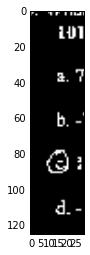

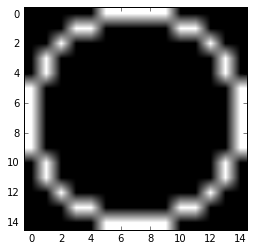

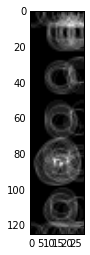

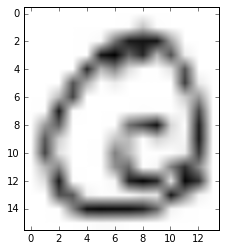

In [66]:
#Question 6

hough_template = np.zeros((15, 15))
rr, cc = circle_perimeter(hough_template.shape[0]/2, hough_template.shape[1]/2, 7)
hough_template[rr, cc] = 1
hough_template = 255 - hough_template

thresh1 = threshold_otsu(question8_img)
binary = question8_img > thresh1
binary  = 255 - binary

thresh2 = threshold_otsu(hough_template)
binary2 = hough_template > thresh2
binary2 = 255 - binary2

im = binary
refim = binary2

table = buildRefTable(refim)
acc = matchTable(im, table)
val, ridx, cidx = findMaxima(acc)

selected_answer = question8_img[ridx-8:ridx+8, cidx-5:cidx+9]

plt.imshow(binary, cmap='gray')
plt.figure()
plt.imshow(binary2, cmap='gray')
plt.figure()
plt.imshow(acc, cmap='gray')
plt.figure()
plt.imshow(selected_answer, cmap='gray')

maximum_response = 0
maximum_option = ""

output, i, j, maxi = ncorrMatching(selected_answer, optiona_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "a"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optionb_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "b"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optionc_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "c"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optiond_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "d"
#plt.figure()
#plt.imshow(output, cmap='gray')

student_responses['8'] = maximum_option

Max is 8.06191582162
Max is 33.0100734317
Max is 20.6394526022
Max is 22.91533645


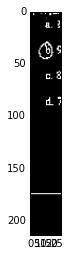

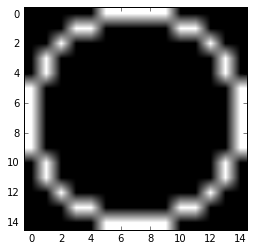

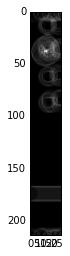

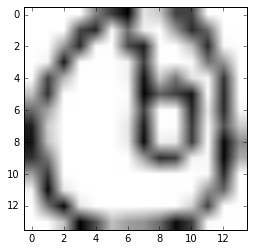

In [67]:
#Question 9

hough_template = np.zeros((15, 15))
rr, cc = circle_perimeter(hough_template.shape[0]/2, hough_template.shape[1]/2, 7)
hough_template[rr, cc] = 1
hough_template = 255 - hough_template

thresh1 = threshold_otsu(question9_img)
binary = question9_img > thresh1
binary  = 255 - binary

thresh2 = threshold_otsu(hough_template)
binary2 = hough_template > thresh2
binary2 = 255 - binary2

im = binary
refim = binary2

table = buildRefTable(refim)
acc = matchTable(im, table)
val, ridx, cidx = findMaxima(acc)

selected_answer = question9_img[ridx-7:ridx+7, cidx-7:cidx+7]

plt.imshow(binary, cmap='gray')
plt.figure()
plt.imshow(binary2, cmap='gray')
plt.figure()
plt.imshow(acc, cmap='gray')
plt.figure()
plt.imshow(selected_answer, cmap='gray')

maximum_response = 0
maximum_option = ""

output, i, j, maxi = ncorrMatching(selected_answer, optiona_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "a"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optionb_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "b"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optionc_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "c"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optiond_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "d"
#plt.figure()
#plt.imshow(output, cmap='gray')

student_responses['9'] = maximum_option

Max is 60.4853395289
Max is 48.1085400667
Max is 48.4866413085
Max is 56.676998115


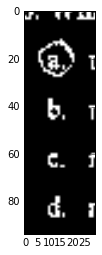

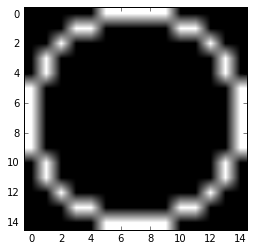

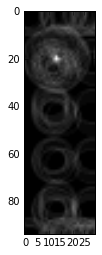

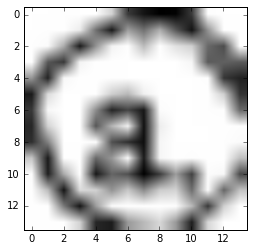

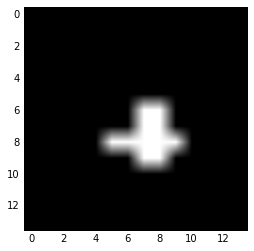

In [68]:
#Question 10

hough_template = np.zeros((15, 15))
rr, cc = circle_perimeter(hough_template.shape[0]/2, hough_template.shape[1]/2, 7)
hough_template[rr, cc] = 1
hough_template = 255 - hough_template

thresh1 = threshold_otsu(question10_img)
binary = question10_img > thresh1
binary  = 255 - binary

thresh2 = threshold_otsu(hough_template)
binary2 = hough_template > thresh2
binary2 = 255 - binary2

im = binary
refim = binary2

table = buildRefTable(refim)
acc = matchTable(im, table)
val, ridx, cidx = findMaxima(acc)

selected_answer = question10_img[ridx-7:ridx+7, cidx-7:cidx+7]

plt.imshow(binary, cmap='gray')
plt.figure()
plt.imshow(binary2, cmap='gray')
plt.figure()
plt.imshow(acc, cmap='gray')
plt.figure()
plt.imshow(selected_answer, cmap='gray')

maximum_response = 0
maximum_option = ""

output, i, j, maxi = ncorrMatching(selected_answer, optiona_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "a"
#plt.figure()
#plt.imshow(output, cmap='gray')

plt.figure()
plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optionb_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "b"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optionc_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "c"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optiond_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "d"
#plt.figure()
#plt.imshow(output, cmap='gray')

student_responses['10'] = maximum_option

159 11
Max is 26.7359042096
Max is 21.3481915636
Max is 24.1318992879
Max is 24.7708197262


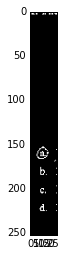

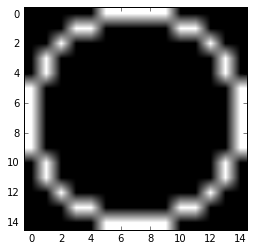

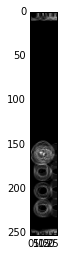

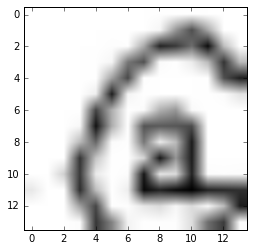

In [69]:
#Question 11

hough_template = np.zeros((15, 15))
rr, cc = circle_perimeter(hough_template.shape[0]/2, hough_template.shape[1]/2, 7)
hough_template[rr, cc] = 1
hough_template = 255 - hough_template

thresh1 = threshold_otsu(question11_img)
binary = question11_img > thresh1
binary  = 255 - binary

thresh2 = threshold_otsu(hough_template)
binary2 = hough_template > thresh2
binary2 = 255 - binary2

im = binary
refim = binary2

table = buildRefTable(refim)
acc = matchTable(im, table)
val, ridx, cidx = findMaxima(acc)
print ridx, cidx
selected_answer = question11_img[ridx-7:ridx+7, cidx-7:cidx+7]

plt.imshow(binary, cmap='gray')
plt.figure()
plt.imshow(binary2, cmap='gray')
plt.figure()
plt.imshow(acc, cmap='gray')
plt.figure()
plt.imshow(selected_answer, cmap='gray')

maximum_response = 0
maximum_option = ""

output, i, j, maxi = ncorrMatching(selected_answer, optiona_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "a"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optionb_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "b"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optionc_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "c"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optiond_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "d"
#plt.figure()
#plt.imshow(output, cmap='gray')

student_responses['11'] = maximum_option

255 9
Max is 50.6479654071
Max is 48.0200545873
Max is 52.724690586
Max is 81.0640400564


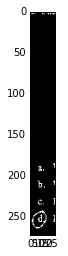

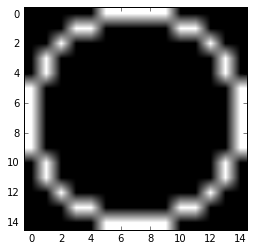

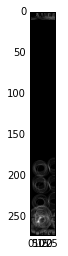

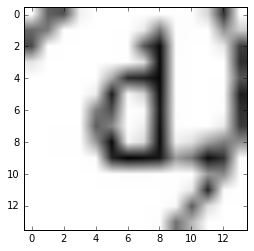

In [70]:
#Question 12

hough_template = np.zeros((15, 15))
rr, cc = circle_perimeter(hough_template.shape[0]/2, hough_template.shape[1]/2, 7)
hough_template[rr, cc] = 1
hough_template = 255 - hough_template

thresh1 = threshold_otsu(question12_img)
binary = question12_img > thresh1
binary  = 255 - binary

thresh2 = threshold_otsu(hough_template)
binary2 = hough_template > thresh2
binary2 = 255 - binary2

im = binary
refim = binary2

table = buildRefTable(refim)
acc = matchTable(im, table)
val, ridx, cidx = findMaxima(acc)
print ridx, cidx
selected_answer = question12_img[ridx-9:ridx+5, cidx-4:cidx+10]

plt.imshow(binary, cmap='gray')
plt.figure()
plt.imshow(binary2, cmap='gray')
plt.figure()
plt.imshow(acc, cmap='gray')
plt.figure()
plt.imshow(selected_answer, cmap='gray')

maximum_response = 0
maximum_option = ""

output, i, j, maxi = ncorrMatching(selected_answer, optiona_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "a"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optionb_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "b"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optionc_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "c"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optiond_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "d"
#plt.figure()
#plt.imshow(output, cmap='gray')

student_responses['12'] = maximum_option

82 14
Max is 39.5097463068
Max is 53.060998573
Max is 42.9780156496
Max is 63.4779900303


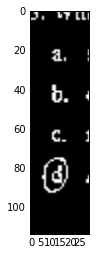

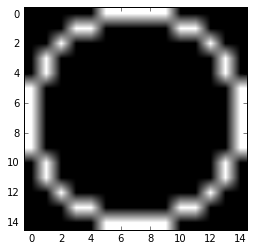

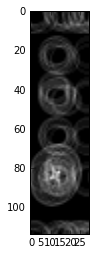

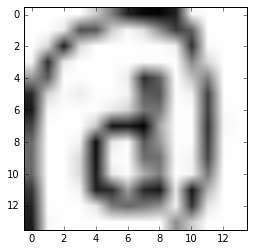

In [71]:
#Question 13

hough_template = np.zeros((15, 15))
rr, cc = circle_perimeter(hough_template.shape[0]/2, hough_template.shape[1]/2, 7)
hough_template[rr, cc] = 1
hough_template = 255 - hough_template

thresh1 = threshold_otsu(question13_img)
binary = question13_img > thresh1
binary  = 255 - binary

thresh2 = threshold_otsu(hough_template)
binary2 = hough_template > thresh2
binary2 = 255 - binary2

im = binary
refim = binary2

table = buildRefTable(refim)
acc = matchTable(im, table)
val, ridx, cidx = findMaxima(acc)
print ridx, cidx
selected_answer = question13_img[ridx-7:ridx+7, cidx-7:cidx+7]

plt.imshow(binary, cmap='gray')
plt.figure()
plt.imshow(binary2, cmap='gray')
plt.figure()
plt.imshow(acc, cmap='gray')
plt.figure()
plt.imshow(selected_answer, cmap='gray')

maximum_response = 0
maximum_option = ""

output, i, j, maxi = ncorrMatching(selected_answer, optiona_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "a"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optionb_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "b"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optionc_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "c"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optiond_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "d"
#plt.figure()
#plt.imshow(output, cmap='gray')

student_responses['13'] = maximum_option

100 13
Max is 52.3706247025
Max is 67.219136336
Max is 43.6663380023
Max is 50.0047395436


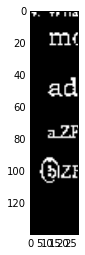

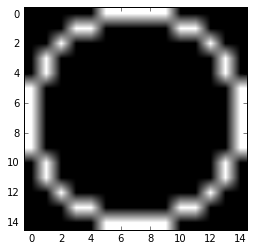

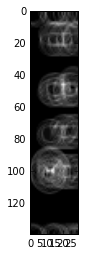

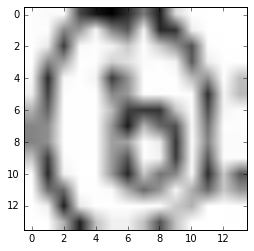

In [72]:
#Question 14

hough_template = np.zeros((15, 15))
rr, cc = circle_perimeter(hough_template.shape[0]/2, hough_template.shape[1]/2, 7)
hough_template[rr, cc] = 1
hough_template = 255 - hough_template

thresh1 = threshold_otsu(question14_img)
binary = question14_img > thresh1
binary  = 255 - binary

thresh2 = threshold_otsu(hough_template)
binary2 = hough_template > thresh2
binary2 = 255 - binary2

im = binary
refim = binary2

table = buildRefTable(refim)
acc = matchTable(im, table)
val, ridx, cidx = findMaxima(acc)
print ridx, cidx
selected_answer = question14_img[ridx-7:ridx+7, cidx-7:cidx+7]

plt.imshow(binary, cmap='gray')
plt.figure()
plt.imshow(binary2, cmap='gray')
plt.figure()
plt.imshow(acc, cmap='gray')
plt.figure()
plt.imshow(selected_answer, cmap='gray')

maximum_response = 0
maximum_option = ""

output, i, j, maxi = ncorrMatching(selected_answer, optiona_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "a"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optionb_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "b"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optionc_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "c"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optiond_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "d"
#plt.figure()
#plt.imshow(output, cmap='gray')

student_responses['14'] = maximum_option

98 11
Max is 33.0395877858
Max is 63.1432037665
Max is 39.4394320757
Max is 31.1965283299


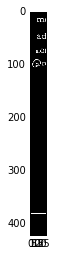

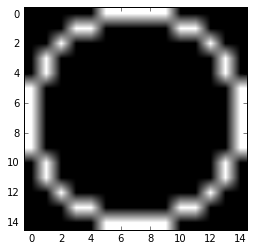

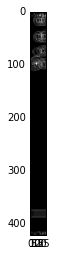

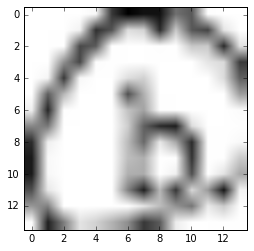

In [73]:
#Question 15

hough_template = np.zeros((15, 15))
rr, cc = circle_perimeter(hough_template.shape[0]/2, hough_template.shape[1]/2, 7)
hough_template[rr, cc] = 1
hough_template = 255 - hough_template

thresh1 = threshold_otsu(question15_img)
binary = question15_img > thresh1
binary  = 255 - binary

thresh2 = threshold_otsu(hough_template)
binary2 = hough_template > thresh2
binary2 = 255 - binary2

im = binary
refim = binary2

table = buildRefTable(refim)
acc = matchTable(im, table)
val, ridx, cidx = findMaxima(acc)
print ridx, cidx
selected_answer = question15_img[ridx-7:ridx+7, cidx-7:cidx+7]

plt.imshow(binary, cmap='gray')
plt.figure()
plt.imshow(binary2, cmap='gray')
plt.figure()
plt.imshow(acc, cmap='gray')
plt.figure()
plt.imshow(selected_answer, cmap='gray')

maximum_response = 0
maximum_option = ""

output, i, j, maxi = ncorrMatching(selected_answer, optiona_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "a"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optionb_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "b"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optionc_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "c"
#plt.figure()
#plt.imshow(output, cmap='gray')

output, i, j, maxi = ncorrMatching(selected_answer, optiond_template, 10)
if maxi > maximum_response:
    maximum_response = maxi
    maximum_option = "d"
#plt.figure()
#plt.imshow(output, cmap='gray')

student_responses['15'] = maximum_option

In [74]:
print student_responses

{'11': 'a', '10': 'a', '13': 'd', '12': 'd', '15': 'b', '14': 'b', '1': 'd', '3': 'd', '2': 'd', '5': 'd', '4': 'c', '7': 'a', '6': 'b', '9': 'b', '8': 'c'}


In [75]:
for i in range(1, 16):
    print "Question ", i, " => ", student_responses[str(i)]

Question  1  =>  d
Question  2  =>  d
Question  3  =>  d
Question  4  =>  c
Question  5  =>  d
Question  6  =>  b
Question  7  =>  a
Question  8  =>  c
Question  9  =>  b
Question  10  =>  a
Question  11  =>  a
Question  12  =>  d
Question  13  =>  d
Question  14  =>  b
Question  15  =>  b
